# Organizational Sentiment Forecasting Pipeline

This notebook demonstrates the end-to-end pipeline for generating synthetic organizational data and forecasting sentiment using an agentic approach.

### Pipeline Steps:
1. **Generate Hidden State**: Create a synthetic organization with employees, relationships, and cultural context.
2. **Encode Narrative (Optional)**: Convert the raw data into a natural language story.
3. **Generate Forecast**: Use a deterministic Python-based engine (with LLM-generated rationales) to predict sentiment propagation.
4. **Analyze & Visualize**: Explore the results, including "Public vs. Private" sentiment gaps and influence networks.


--- Visualizing Collaboration Graph ---


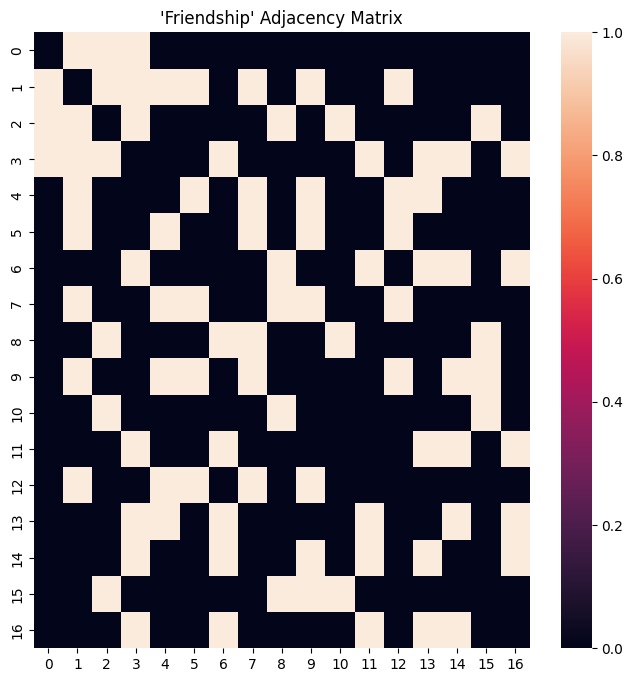

✓ Imports successful


In [1]:
import json
import os
import sys
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set random seed for reproducibility
np.random.seed(29)

# Import pipeline modules
from hidden_state_generation import (
    sample_org_seed,
    sample_rec_seed,
    sample_situation_seed,
    OrganizationHiddenState
)
from encoder_layer import create_encoded_narrative
from forward_forecaster import forecast_scenario
# Import visualization tools
from visualize_results import analyze_public_private_divergence, plot_influence_network

print("✓ Imports successful")

### Manual Parameter Configuration

To test specific parameter combinations, you can manually override values in the next cell:

**Key Parameters to Test:**

1. **Organizational Culture** (`org_seed`):
   - `past_change_success`: Low values (0.0-0.3) = high cynicism → lower baseline support
   - `sanction_salience`: High values (0.7-1.0) = more sensitive to sanctions → stronger compliance
   - `in_group_bias`: High values (0.7-1.0) = strong department loyalty → more resistance to external influence
   - `power_distance`: High values (0.7-1.0) = hierarchical → level effects are stronger

2. **Recommendation** (`rec_seed`):
   - `theta_ideal`: Ideal policy position (0.0-1.0)
   - `urgency`: High values (0.7-1.0) = time pressure → increases support
   - `resource_need`: High values (0.7-1.0) = resource-intensive → affects baseline

3. **Situation** (`sit_seed`):
   - `theta_current`: Current org position (0.0-1.0)
   - `sanction_strength`: High values (0.7-1.0) = strong consequences → lower safety scores
   - `provocation_flag`: 1 = recent destabilizing events → amplifies conflict effects
   - `visibility_flag`: 0 = private, 1 = public → affects safety scores

**Example Test Scenarios:**
- **High Cynicism**: `past_change_success = 0.2` → Should see lower baseline support
- **Strong Sanctions**: `sanction_strength = 0.9` → Should see suppressed opposition (organizational silence)
- **Large Theta Gap (Aligned)**: `theta_ideal = 0.9, theta_current = 0.1` → Should see strong alignment effects
- **Provocation**: `provocation_flag = 1` → Should amplify conflict and reduce alignment effects
- **Strong Misalignment (NEW)**: `theta_ideal = 0.2, theta_current = 0.8` → Should see strong resistance (loss aversion + tribalism)
- **Tribal Misalignment**: `theta_ideal = 0.1, theta_current = 0.9, in_group_bias = 0.8` → Maximum resistance from tribal groups


## 1. Generate Hidden Organizational State

We start by creating a synthetic organization. This includes:
- **Employees**: Roles, departments, tenure, personality traits (openness, performance).
- **Culture**: Values like 'past_change_success' (cynicism) and 'psychological_safety'.
- **Graphs**: Networks for reporting lines, collaboration, friendship, influence, and conflict.

In [2]:
# 1.1 Sample random seeds for the organization context
org_seed = sample_org_seed(seed=116)
rec_seed = sample_rec_seed(seed=265)
sit_seed = sample_situation_seed(seed=659)

# ============================================================================
# MANUAL PARAMETER OVERRIDE (Optional)
# ============================================================================
# Uncomment and modify the parameters below to test specific configurations
# This allows you to override randomly sampled values with fixed values

MANUAL_OVERRIDE = True  # Set to True to use manual values
# MANUAL_OVERRIDE = False  # Set to False to use random seeds

if MANUAL_OVERRIDE:
    # Organizational Context Parameters (org_seed)
    # These affect baseline cultural traits
    org_seed['past_change_success'] = 0.3  # Low = high cynicism (0.0-1.0)
    org_seed['sanction_salience'] = 0.8    # High = more sensitive to sanctions (0.0-1.0)
    org_seed['in_group_bias'] = 0.2         # High = strong department loyalty (0.0-1.0)
    org_seed['power_distance'] = 0.6       # High = hierarchical culture (0.0-1.0)
    # org_seed['industry_id'] = 0  # 0=tech, 1=finance, 2=healthcare, 3=manufacturing, 4=government
    
    # Recommendation Parameters (rec_seed)
    # These affect the nature of the recommendation
    rec_seed['theta_ideal'] = 0.8          # Ideal policy position (0.0-1.0)
    rec_seed['urgency'] = 0.9               # Time pressure (0.0-1.0)
    rec_seed['resource_need'] = 0.9         # Resource intensity (0.0-1.0)
    # rec_seed['domain_id'] = 0  # 0=product_roadmap, 1=hiring, 2=budget, etc.
    
    # Situation Parameters (sit_seed)
    # These affect the current organizational state
    sit_seed['theta_current'] = 0.8         # Current org position (0.0-1.0)
    sit_seed['sanction_strength'] = 0.5     # Consequence severity (0.0-1.0)
    sit_seed['provocation_flag'] = 0        # Recent destabilizing events (0 or 1)
    # sit_seed['visibility_flag'] = 0  # 0=private, 1=public
    
    print("⚠ Using MANUAL parameter overrides")
else:
    print("✓ Using random seed-generated parameters")

print("\nContext Seeds:")
print(f"  Industry: {org_seed['industry_id']} (mapped later)")
print(f"  Change Cynicism (Past Success): {org_seed['past_change_success']:.2f}")
print(f"  Sanction Strength: {sit_seed['sanction_strength']:.2f}")
print(f"  Theta Alignment: {rec_seed['theta_ideal']:.2f} - {sit_seed['theta_current']:.2f} = {rec_seed['theta_ideal'] - sit_seed['theta_current']:.2f}")

# 1.2 Generate the full hidden state
hidden_state = OrganizationHiddenState(
    org_seed=org_seed,
    rec_seed=rec_seed,
    situation_seed=sit_seed,
    departments=['Engineering', 'Marketing', 'Sales', 'HR'],
    avg_span_of_control=5
)

# Convert to dictionary for the pipeline
json_output = hidden_state.to_json_encoding()
hidden_state_dict = json.loads(json_output)

print(f"\n✓ Generated Organization: {hidden_state.N} employees")
print(f"  Departments: {list(hidden_state.employees['department'].unique())}")

# Show a sample of the employee roster
print("\nEmployee Roster (Sample):")
print(hidden_state.employees[['employee_id', 'level', 'department', 'tenure', 'performance', 'openness']].head())

⚠ Using MANUAL parameter overrides

Context Seeds:
  Industry: 1 (mapped later)
  Change Cynicism (Past Success): 0.30
  Sanction Strength: 0.50
  Theta Alignment: 0.80 - 0.80 = 0.00

✓ Generated Organization: 7 employees
  Departments: ['HR', 'Sales', 'Marketing', 'Engineering']

Employee Roster (Sample):
   employee_id     level   department  tenure  performance  openness
0            0   C-Suite           HR       7     0.682776  0.415773
1            1  Director        Sales      10     0.522059  0.467237
2            2   Manager    Marketing       8     0.474445  0.561991
3            3   Manager  Engineering       4     0.683191  0.537666
4            4   Manager  Engineering      10     0.776250  0.354374


In [3]:
# Parameter Summary (for reference)
# This cell displays all key parameters that will affect the forecast

from hidden_state_generation import INDUSTRIES, SIZES, RECOMMENDATION_DOMAINS, VISIBILITY

print("=" * 60)
print("CONFIGURED PARAMETERS SUMMARY")
print("=" * 60)

print("\n📊 Organizational Context (org_seed):")
print(f"  Industry: {INDUSTRIES[org_seed['industry_id']]}")
print(f"  Past Change Success: {org_seed['past_change_success']:.2f} (Low = High Cynicism)")
print(f"  Sanction Salience: {org_seed['sanction_salience']:.2f} (High = More Sensitive)")
print(f"  In-Group Bias: {org_seed['in_group_bias']:.2f} (High = Strong Dept Loyalty)")
print(f"  Power Distance: {org_seed['power_distance']:.2f} (High = Hierarchical)")

print("\n💡 Recommendation (rec_seed):")
print(f"  Domain: {RECOMMENDATION_DOMAINS[rec_seed['domain_id']]}")
print(f"  Theta Ideal: {rec_seed['theta_ideal']:.2f}")
print(f"  Urgency: {rec_seed['urgency']:.2f} (High = Time Pressure)")
print(f"  Resource Need: {rec_seed['resource_need']:.2f} (High = Resource Intensive)")

print("\n🌐 Situation (sit_seed):")
print(f"  Theta Current: {sit_seed['theta_current']:.2f}")
print(f"  Theta Alignment: {rec_seed['theta_ideal'] - sit_seed['theta_current']:.2f}")
print(f"  Visibility: {VISIBILITY[sit_seed['visibility_flag']]}")
print(f"  Sanction Strength: {sit_seed['sanction_strength']:.2f} (High = Strong Consequences)")
print(f"  Provocation Flag: {sit_seed['provocation_flag']} (1 = Recent Destabilizing Events)")

print("\n" + "=" * 60)


CONFIGURED PARAMETERS SUMMARY

📊 Organizational Context (org_seed):
  Industry: finance
  Past Change Success: 0.30 (Low = High Cynicism)
  Sanction Salience: 0.80 (High = More Sensitive)
  In-Group Bias: 0.20 (High = Strong Dept Loyalty)
  Power Distance: 0.60 (High = Hierarchical)

💡 Recommendation (rec_seed):
  Domain: market_entry
  Theta Ideal: 0.80
  Urgency: 0.90 (High = Time Pressure)
  Resource Need: 0.90 (High = Resource Intensive)

🌐 Situation (sit_seed):
  Theta Current: 0.80
  Theta Alignment: 0.00
  Visibility: private
  Sanction Strength: 0.50 (High = Strong Consequences)
  Provocation Flag: 0 (1 = Recent Destabilizing Events)



## 2. Encode Narrative

We convert the structured data into a natural language narrative. This mimics the "context" an LLM would typically receive, but here we fuse it with the structured hidden state for hybrid forecasting.

In [4]:
print("Generating narrative context...")
try:
    narrative_data = create_encoded_narrative(hidden_state_dict)
    print("✓ Narrative generated successfully")
    print(f"\nScenario Preview:\n{narrative_data.get('recommendation_scenario', 'N/A')[:300]}...")
except Exception as e:
    print(f"⚠ Error generating narrative: {e}")
    narrative_data = None

Generating narrative context...
Error in generate_company_story: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error analyzing graph 'reports_to': Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error analyzing graph 'collaboration': Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'ty

## 3. Generate Forecast

The core engine runs a deterministic simulation of opinion dynamics:
1. **Baseline Scores**: Calculated from individual traits (openness, performance), context (cynicism), and incentives.
2. **Network Influence**: Opinions propagate via social graphs (friendship, collaboration).
   - **Complex Contagion**: Skeptics need multiple strong supporters to switch.
   - **Opinion Leaders**: High PageRank employees have more sway.
3. **Public vs. Private**: If `safety_score` is low, dissent is suppressed (silence/compliance).
4. **Rationale**: An LLM generates a qualitative explanation of the results.

In [5]:
print("Running agentic forecast simulation...")

forecast = forecast_scenario(
    hidden_state=hidden_state_dict,
    scenario_id="demo_scenario",
    model="gpt-4o-mini",
    horizon="decision",
    narrative_context=narrative_data
)

if "error" in forecast and forecast.get("error"):
    print(f"❌ Forecast failed: {forecast.get('error_message')}")
else:
    print("✓ Forecast complete")
    
    # Print High-Level Results
    agg = forecast['aggregate_outcomes']
    print(f"\nPredicted Outcome: {agg['top_class'].upper()} ({agg['probabilities'][agg['top_class']]:.1%})")
    print(f"Rationale: {forecast.get('rationale', 'N/A')}")

Running agentic forecast simulation...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
✓ Forecast complete

Predicted Outcome: SUPPORT (34.3%)
Rationale: N/A


## 4. Analyze & Visualize Dynamics

Here we uncover the hidden dynamics of the forecast, specifically the gap between **Psychological Safety** and **Public Expression**.

Analyzing Psychological Safety vs. Public Expression...

Diagnostic Info:
  Sanction Strength: 0.500
  Visibility: private
  Safety Score Range: 0.762 to 1.000
  Employees with Safety < 0.5 (gradual suppression): 0/7
  Safety Score Std Dev: 0.093 (higher = more variance)


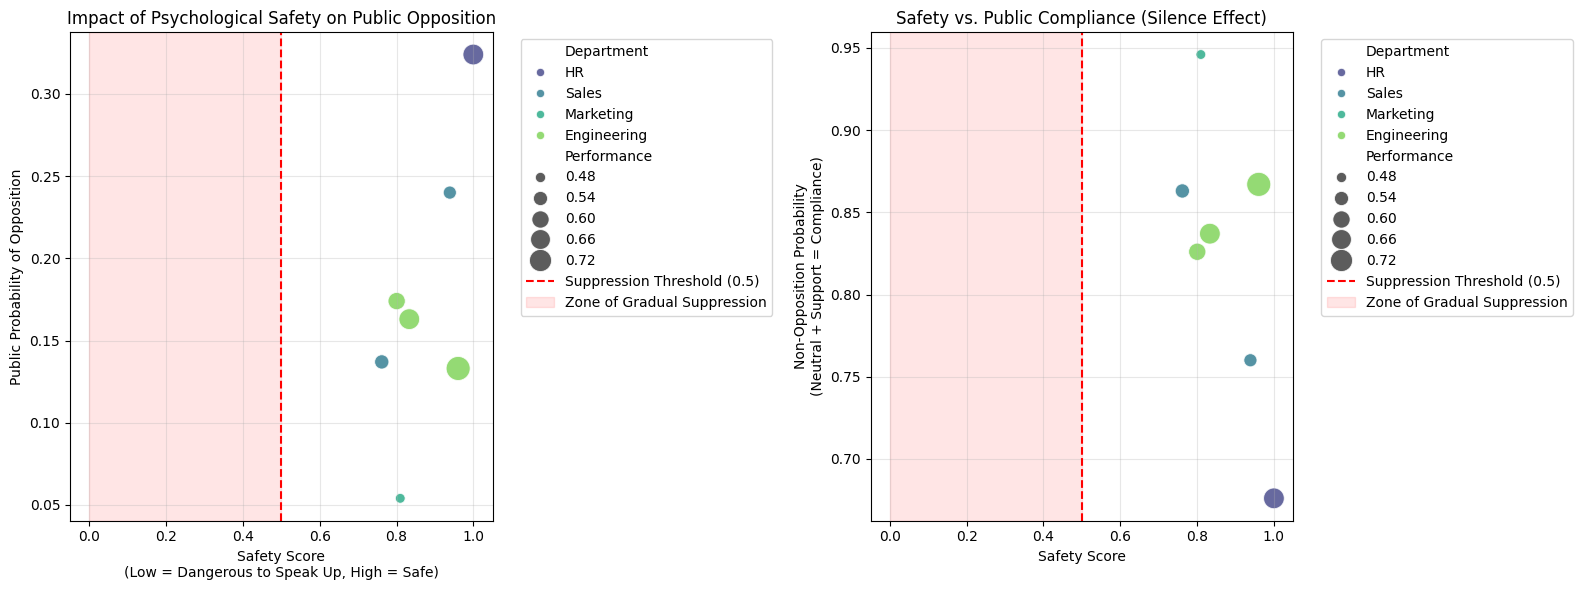


No significant organizational silence detected in this scenario.


In [6]:
# 4.1 Public vs. Private Sentiment Gap
# This plot shows how low safety scores (x-axis) lead to suppressed opposition (y-axis).

print("Analyzing Psychological Safety vs. Public Expression...")
df_analysis = analyze_public_private_divergence(hidden_state_dict, forecast)

# Identify "Silenced" Employees
# Those with Low Safety (< 0.5, where gradual suppression occurs) but who are complying (High Non-Opposition)
silenced = df_analysis[
    (df_analysis['Safety Score'] < 0.5) & 
    (df_analysis['Non-Opposition (Compliance)'] > 0.5)
]

if not silenced.empty:
    print(f"\n⚠ ALERT: {len(silenced)} employees may be practicing 'Organizational Silence'.")
    print("They likely oppose privately but feel unsafe to speak up.")
    print(silenced[['Employee ID', 'Department', 'Safety Score', 'Public Oppose', 'Non-Opposition (Compliance)']])
else:
    print("\nNo significant organizational silence detected in this scenario.")

Visualizing Influence Network...


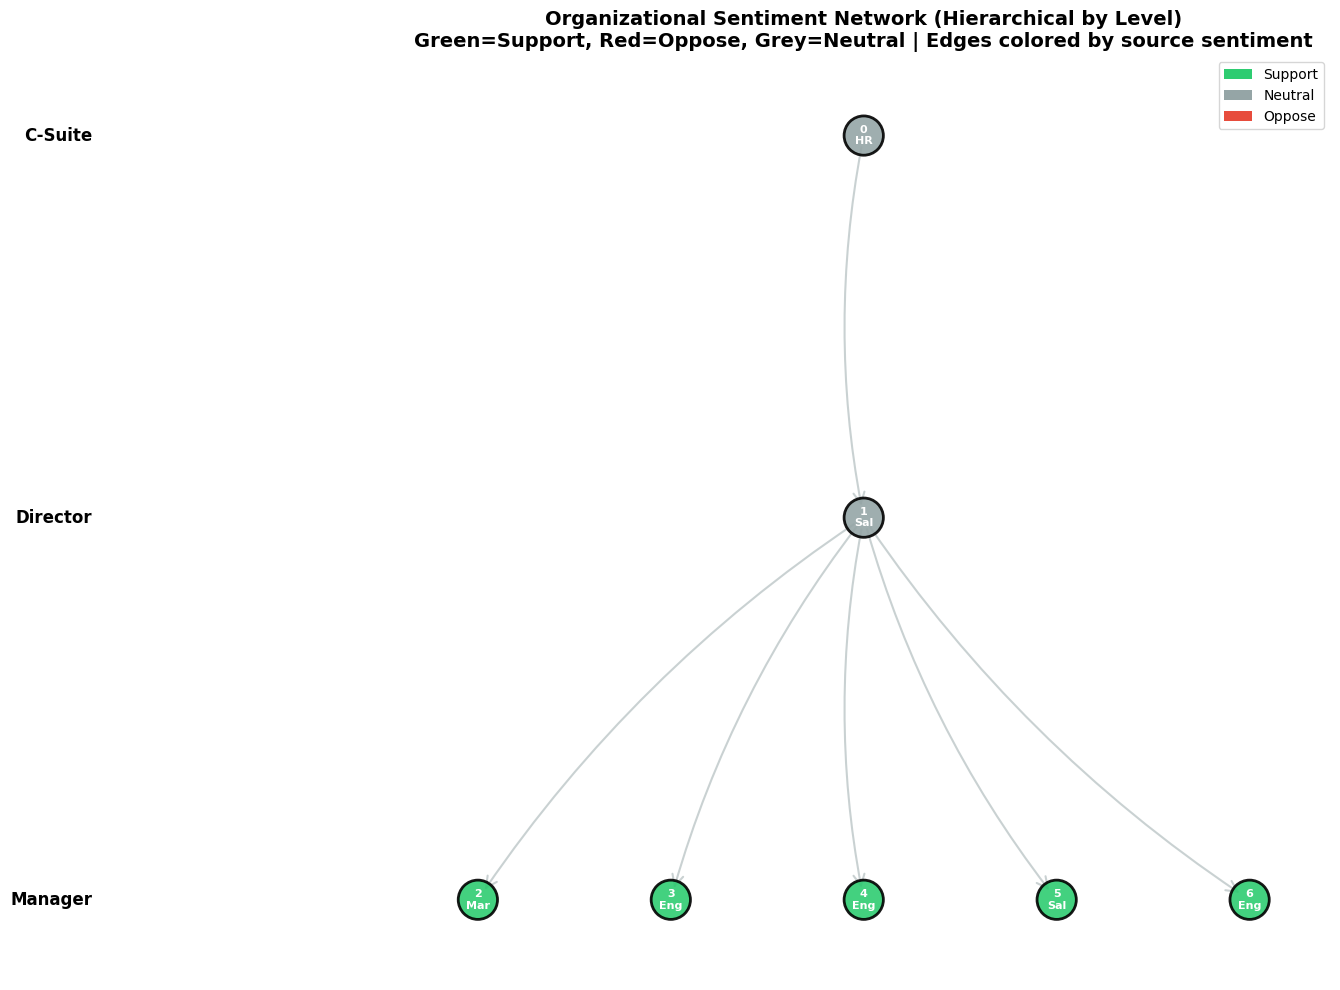

In [7]:
# 4.2 Influence Network
# Visualize how sentiment clusters in the network. 
# Green = Support, Red = Oppose, Grey = Neutral

print("Visualizing Influence Network...")
plot_influence_network(hidden_state_dict, forecast)

In [8]:
# 4.3 Detailed Probability Breakdown
print("Detailed Forecast Breakdown (Top 10 Employees):")
df_probs = pd.DataFrame([
    {
        'ID': s['employee_id'],
        'Sentiment': s['sentiment'],
        'Oppose': s['probabilities']['oppose'],
        'Neutral': s['probabilities']['neutral'],
        'Support': s['probabilities']['support']
    } 
    for s in forecast['individual_sentiments']
])

print(df_probs.head(10))

Detailed Forecast Breakdown (Top 10 Employees):
   ID Sentiment  Oppose  Neutral  Support
0   0   support   0.324    0.333    0.343
1   1   support   0.240    0.324    0.436
2   2   support   0.054    0.201    0.745
3   3   support   0.163    0.297    0.540
4   4   support   0.133    0.279    0.588
5   5   support   0.137    0.282    0.581
6   6   support   0.174    0.302    0.524


## 5. Sensitivity Analysis: Individual Trait Variability

This section explores how stochastic individual trait initialization affects sentiment outcomes. 

**Question**: Given the same organizational context (seeds), how much do individual personality traits (openness, performance, sanction_salience, in_group_bias) influence the final sentiment distribution?

We'll run multiple forecasts with different employee initializations and visualize the distribution of outcomes for the top 5 most variable actors.


In [9]:
# 5.1 Run multiple forecasts with different employee initializations
print("Running sensitivity analysis with multiple employee initializations...")
print("This keeps org/rec/situation seeds constant, but varies individual traits.\n")

num_runs = 30  # Number of different employee initializations to test
results_by_employee = {}  # Store results: {employee_id: [list of probability dicts]}

for run_idx in range(num_runs):
    if run_idx % 5 == 0:
        print(f"  Run {run_idx + 1}/{num_runs}...")
    
    # Generate a new hidden state with the SAME seeds but different random employee traits
    # (The random initialization happens inside OrganizationHiddenState)
    temp_hidden_state = OrganizationHiddenState(
        org_seed=org_seed,
        rec_seed=rec_seed,
        situation_seed=sit_seed,
        departments=['Engineering', 'Marketing', 'Sales', 'HR'],
        avg_span_of_control=5
    )
    
    temp_json = temp_hidden_state.to_json_encoding()
    temp_dict = json.loads(temp_json)
    
    # Run forecast WITHOUT narrative (faster, focuses on computational dynamics)
    # Note: Rationale generation may fail silently, which is fine for this analysis
    temp_forecast = forecast_scenario(
        hidden_state=temp_dict,
        scenario_id=f"sensitivity_run_{run_idx}",
        model="gpt-4o-mini",
        horizon="decision",
        narrative_context=None  # Skip narrative for speed
    )
    
    if "error" in temp_forecast and temp_forecast.get("error"):
        print(f"    Warning: Run {run_idx} failed, skipping...")
        continue
    
    # Store results for each employee
    for sentiment in temp_forecast['individual_sentiments']:
        emp_id = sentiment['employee_id']
        probs = sentiment['probabilities']
        
        if emp_id not in results_by_employee:
            results_by_employee[emp_id] = []
        
        results_by_employee[emp_id].append({
            'oppose': probs['oppose'],
            'neutral': probs['neutral'],
            'support': probs['support'],
            'run': run_idx
        })

print(f"\n✓ Collected {num_runs} runs for {len(results_by_employee)} employees")


Running sensitivity analysis with multiple employee initializations...
This keeps org/rec/situation seeds constant, but varies individual traits.

  Run 1/30...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
  Run 6/30...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
⚠ Rate limit hit. Waiting 1.0 seconds...
⚠ Rate limit hit. Waiting 2.0 seconds...
  Run

In [10]:
# 5.2 Identify the top 5 most variable employees
# Calculate variance in support probability for each employee
employee_variability = []

for emp_id, probs_list in results_by_employee.items():
    support_probs = [p['support'] for p in probs_list]
    oppose_probs = [p['oppose'] for p in probs_list]
    
    variance = np.var(support_probs)
    mean_support = np.mean(support_probs)
    mean_oppose = np.mean(oppose_probs)
    
    employee_variability.append({
        'employee_id': emp_id,
        'support_variance': variance,
        'support_std': np.std(support_probs),
        'mean_support': mean_support,
        'mean_oppose': mean_oppose,
        'support_range': max(support_probs) - min(support_probs)
    })

# Sort by variance and get top 5
employee_variability.sort(key=lambda x: x['support_variance'], reverse=True)
top_5_variable = employee_variability[:5]

print("Top 5 Most Variable Employees (by support probability variance):")
print("=" * 70)
for i, emp in enumerate(top_5_variable, 1):
    print(f"{i}. Employee {emp['employee_id']}: "
          f"Std={emp['support_std']:.3f}, "
          f"Range={emp['support_range']:.3f}, "
          f"Mean Support={emp['mean_support']:.3f}")
print()


Top 5 Most Variable Employees (by support probability variance):
1. Employee 2: Std=0.102, Range=0.347, Mean Support=0.558
2. Employee 3: Std=0.082, Range=0.353, Mean Support=0.571
3. Employee 5: Std=0.081, Range=0.322, Mean Support=0.586
4. Employee 6: Std=0.079, Range=0.242, Mean Support=0.543
5. Employee 7: Std=0.066, Range=0.219, Mean Support=0.545



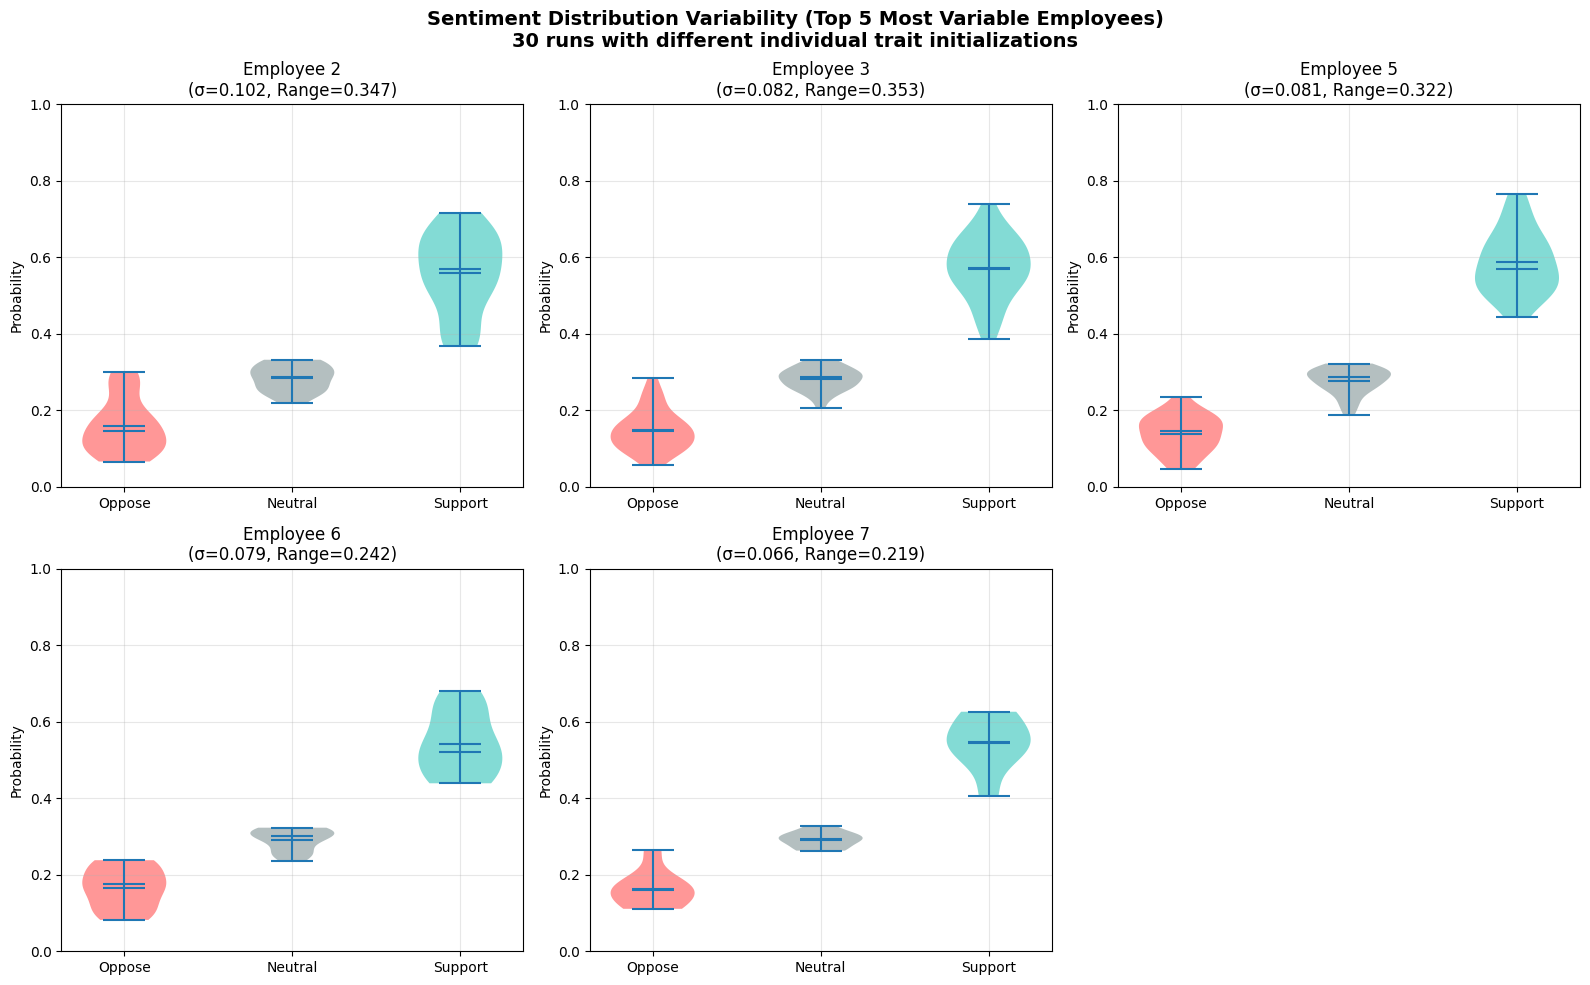

Note: Each violin shows the distribution of 30 different initializations


In [11]:
# 5.3 Visualize sentiment distributions for top 5 most variable employees
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, emp_info in enumerate(top_5_variable):
    emp_id = emp_info['employee_id']
    probs_list = results_by_employee[emp_id]
    
    # Extract probabilities
    oppose_vals = [p['oppose'] for p in probs_list]
    neutral_vals = [p['neutral'] for p in probs_list]
    support_vals = [p['support'] for p in probs_list]
    
    # Create violin plot for this employee
    ax = axes[idx]
    data_for_plot = pd.DataFrame({
        'Oppose': oppose_vals,
        'Neutral': neutral_vals,
        'Support': support_vals
    })
    
    # Violin plot
    positions = [1, 2, 3]
    parts = ax.violinplot([oppose_vals, neutral_vals, support_vals], 
                          positions=positions, 
                          showmeans=True, 
                          showmedians=True)
    
    # Color the violins
    colors = ['#ff6b6b', '#95a5a6', '#4ecdc4']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(['Oppose', 'Neutral', 'Support'])
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)
    ax.set_title(f'Employee {emp_id}\n(σ={emp_info["support_std"]:.3f}, Range={emp_info["support_range"]:.3f})')
    ax.grid(True, alpha=0.3)

# Hide the 6th subplot
axes[5].axis('off')

plt.suptitle(f'Sentiment Distribution Variability (Top 5 Most Variable Employees)\n{num_runs} runs with different individual trait initializations', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Note: Each violin shows the distribution of {num_runs} different initializations")


/var/folders/hz/r1j9xxb93xg7wgj3vk7b3d880000gn/T/ipykernel_86042/382897481.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(support_data, labels=employee_labels, patch_artist=True)


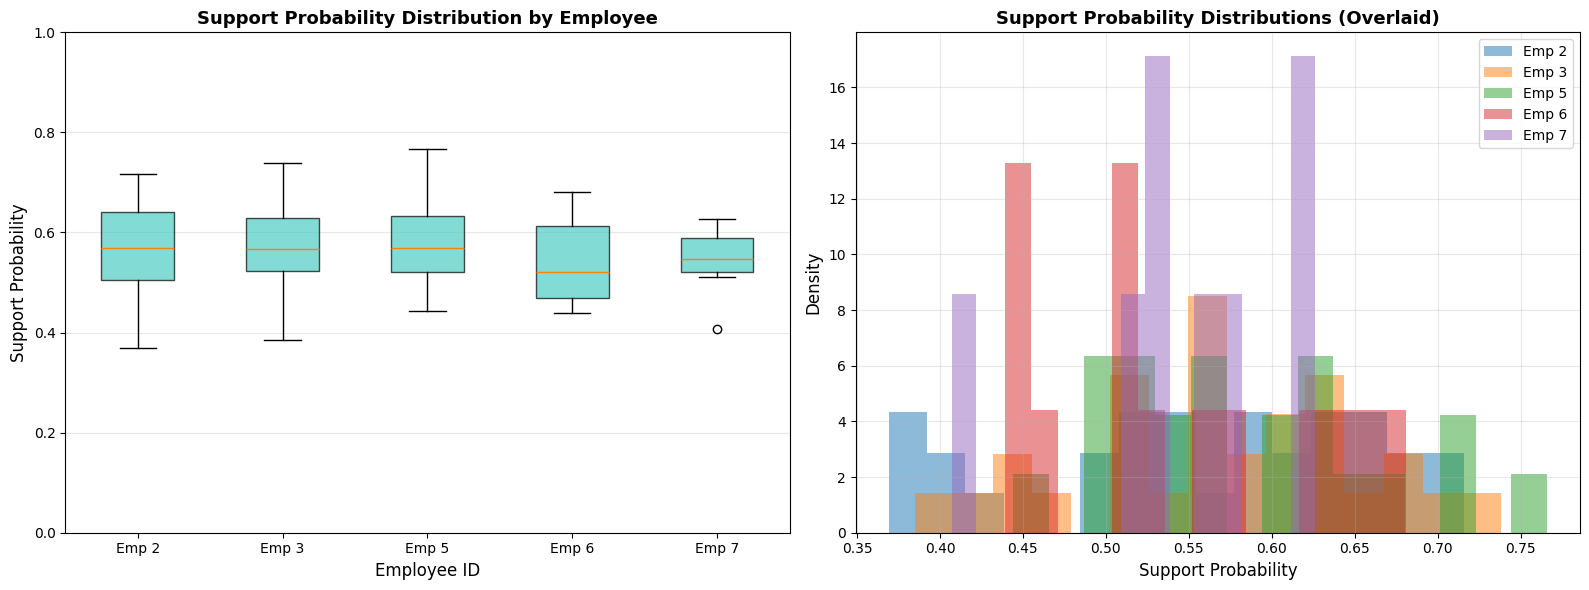


Interpretation:
- Wide distributions indicate high sensitivity to individual trait initialization
- Narrow distributions indicate robust outcomes despite trait variability
- Overlapping distributions suggest similar sensitivities across employees


In [12]:
# 5.4 Joint distribution analysis: Compare outcome distributions across employees
# Create a stacked view showing how different employees' probabilities vary

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Box plot comparison of support probability distributions
support_data = []
employee_labels = []
for emp_info in top_5_variable:
    emp_id = emp_info['employee_id']
    probs_list = results_by_employee[emp_id]
    support_vals = [p['support'] for p in probs_list]
    support_data.append(support_vals)
    employee_labels.append(f"Emp {emp_id}")

bp = ax1.boxplot(support_data, labels=employee_labels, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#4ecdc4')
    patch.set_alpha(0.7)

ax1.set_ylabel('Support Probability', fontsize=12)
ax1.set_xlabel('Employee ID', fontsize=12)
ax1.set_title('Support Probability Distribution by Employee', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 1)

# RIGHT: Distribution density plot (KDE)
for emp_info in top_5_variable:
    emp_id = emp_info['employee_id']
    probs_list = results_by_employee[emp_id]
    support_vals = [p['support'] for p in probs_list]
    
    ax2.hist(support_vals, bins=15, alpha=0.5, label=f'Emp {emp_id}', density=True)

ax2.set_xlabel('Support Probability', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Support Probability Distributions (Overlaid)', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Wide distributions indicate high sensitivity to individual trait initialization")
print("- Narrow distributions indicate robust outcomes despite trait variability")
print("- Overlapping distributions suggest similar sensitivities across employees")


In [13]:
# 5.5 Summary statistics for all employees
print("=" * 80)
print("SENSITIVITY ANALYSIS SUMMARY")
print("=" * 80)

# Calculate overall statistics
all_variances = [emp['support_variance'] for emp in employee_variability]
all_stds = [emp['support_std'] for emp in employee_variability]

print(f"\nOverall Statistics across {len(employee_variability)} employees:")
print(f"  Mean Standard Deviation: {np.mean(all_stds):.4f}")
print(f"  Median Standard Deviation: {np.median(all_stds):.4f}")
print(f"  Max Standard Deviation: {np.max(all_stds):.4f} (Employee {employee_variability[0]['employee_id']})")
print(f"  Min Standard Deviation: {np.min(all_stds):.4f}")

print(f"\nVariability Categories:")
high_var_count = sum(1 for std in all_stds if std > 0.1)
med_var_count = sum(1 for std in all_stds if 0.05 < std <= 0.1)
low_var_count = sum(1 for std in all_stds if std <= 0.05)

print(f"  High variability (σ > 0.1): {high_var_count} employees")
print(f"  Medium variability (0.05 < σ ≤ 0.1): {med_var_count} employees")
print(f"  Low variability (σ ≤ 0.05): {low_var_count} employees")

print(f"\nKey Insight:")
if np.mean(all_stds) > 0.1:
    print("  ⚠ HIGH SENSITIVITY: Individual trait initialization significantly affects outcomes")
elif np.mean(all_stds) > 0.05:
    print("  ⚡ MODERATE SENSITIVITY: Individual traits have noticeable impact on outcomes")
else:
    print("  ✓ LOW SENSITIVITY: Outcomes are robust to individual trait variability")

print("\n" + "=" * 80)


SENSITIVITY ANALYSIS SUMMARY

Overall Statistics across 9 employees:
  Mean Standard Deviation: 0.0630
  Median Standard Deviation: 0.0659
  Max Standard Deviation: 0.1023 (Employee 2)
  Min Standard Deviation: 0.0234

Variability Categories:
  High variability (σ > 0.1): 1 employees
  Medium variability (0.05 < σ ≤ 0.1): 5 employees
  Low variability (σ ≤ 0.05): 3 employees

Key Insight:
  ⚡ MODERATE SENSITIVITY: Individual traits have noticeable impact on outcomes

